In [2]:
import sys
sys.path.append("../")

%load_ext autoreload
%autoreload 2

from datasets import load_dataset
import pandas as pd
from datasets import ClassLabel
import psutil
import matplotlib.pyplot as plt
from collections import defaultdict
from tqdm.auto import tqdm
import numpy as np
from IPython.display import clear_output
import re

import model.fasttext_np_nofeatures as fasttext
import src.model.tokenizer as tokenizer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [63]:
ds = load_dataset("elalber2000/stop-slop-data")["train"]
ds = ds.rename_columns({
    "content": "text",
})

def binarize(example):
    example['label'] = {"Non-Slop": 0, "Slop": 1}[example['slop']]
    return example

ds = ds.map(binarize)

features = ds.features.copy()
features["label"] = ClassLabel(names=["Non-Slop", "Slop"])
ds = ds.cast(features)

In [64]:
splits = ds.train_test_split(
    test_size=0.2,
    stratify_by_column="label",
    seed=42
)
train_ds, val_ds = splits["train"], splits["test"]

In [65]:
# Memory Availability

mem = psutil.virtual_memory()
print(f"Available memory: {mem.available / (1024**2):.2f} MB")
print(f"Total memory: {mem.total / (1024**2):.2f} MB")
print(f"Used memory: {(mem.total - mem.available) / (1024**2):.2f} MB")

Available memory: 1436.87 MB
Total memory: 2987.68 MB
Used memory: 1550.81 MB


In [86]:
tok = tokenizer.FastTextTokenizer(
    bucket_size=int(5e5),
    ngram_size=(3, 4),
    min_subword_freq=3,
    max_token=200,
)
tok.build_subword_mask([ex["text"] for ex in train_ds])

ft = fasttext.FastTextModel(
    num_class=2,
    lr=0.05,
    emb_size=100,
    batch_size=32,
    bucket_size=int(5e5),
    dropout_rate=0,
)

2025-05-06 19:47:41,144 [INFO] Initializing config
2025-05-06 19:47:41,146 [INFO] Initializing parameters
2025-05-06 19:48:07,603 [INFO] Initializing vals


In [87]:
train_texts = [ex["text"] for ex in train_ds]
train_labels = np.array([ex["label"] for ex in train_ds])
train_tokens = tok.batch_encode(train_texts)

val_texts   = [ex["text"] for ex in val_ds]
val_labels  = np.array([ex["label"] for ex in val_ds])
val_tokens  = tok.batch_encode(val_texts)

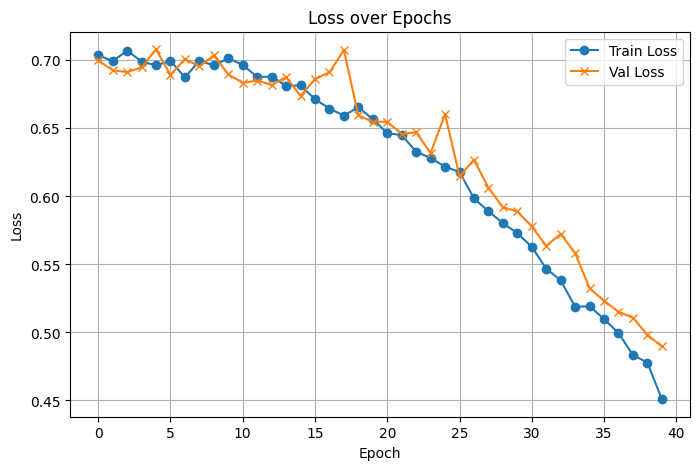

Epoch 40: train=0.4509, val=0.4898


In [88]:
N_EPOCH = 40
train_losses, val_losses = [], []

for epoch in range(1, N_EPOCH + 1):
    perm = np.random.permutation(len(train_tokens))
    epoch_losses = []

    for i in range(0, len(perm), ft.batch_size):
        batch_idx    = perm[i : i + ft.batch_size]
        batch_toks   = [train_tokens[j] for j in batch_idx]
        batch_lbls   = train_labels[batch_idx]
        batch_df     = pd.DataFrame({"text": batch_toks, "label": batch_lbls})

        ft.backward(batch_df)
        epoch_losses.append(ft._loss_vals[-1])

    avg_train = float(np.mean(epoch_losses))
    train_losses.append(avg_train)

    val_df = pd.DataFrame({"text": val_tokens, "label": val_labels})
    vloss  = ft.eval(val_df)
    val_losses.append(vloss)

    clear_output(wait=True)
    plt.figure(figsize=(8,5))
    plt.plot(train_losses, marker='o', label='Train Loss')
    plt.plot(val_losses,   marker='x', label='Val Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss over Epochs")
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"Epoch {epoch:2d}: train={avg_train:.4f}, val={vloss:.4f}")

In [90]:
from collections import defaultdict
from tqdm import tqdm

w_diff = ft.weights[:,1] - ft.weights[:,0]

ngram_scores = defaultdict(lambda: defaultdict(float))
ngram_counts = defaultdict(lambda: defaultdict(int))

for text in tqdm(train_texts, desc="Impact"):
    words      = tok._split(text)
    ngrams_lst = [tok._ngrams(wd) for wd in words]
    ids_lst    = tok.encode(text)

    for word, ngrams, ids in zip(words, ngrams_lst, ids_lst):
        seen = set()
        for ng_str, idx in zip(ngrams, ids):
            if ng_str in seen: continue
            seen.add(ng_str)
            diff = ft.vocab[idx].dot(w_diff)
            key_ng = ng_str if tok.subword_mask[idx] else word
            ngram_scores[key_ng][word] += diff
            ngram_counts[key_ng][word] += 1

# pick the single most impactful word for each ngram
avg_impact = {}
for ng, wd_dict in ngram_scores.items():
    best_w, best_avg = max(
        ((w, s/ngram_counts[ng][w]) for w, s in wd_dict.items()),
        key=lambda x: abs(x[1])
    )
    avg_impact[f"{ng} ({best_w})"] = best_avg

# top 100 by absolute impact
top100 = sorted(avg_impact.items(), key=lambda x: -abs(x[1]))[:100]
for feat, sc in top100:
    print(f"{feat:>25s}: {sc:+.4f}")

Impact: 100%|██████████| 770/770 [00:07<00:00, 108.54it/s]


              <te (teams): -23.1510
               <th (that): -23.1126
             ers (buyers): -20.9368
ber (ofseveralcybersecurityprofessionalsandresearchersonxin): -20.9368
ver (althoughmedicarecovers): -20.9368
     ler (sotrspoilersdo): -20.9368
  ste (groupdjtregisters): -20.9368
her (pyramidsresearchers): -20.9368
        rer (flagbearers): -20.9368
           uums (vacuums): -20.9368
        tech (techcrunch): -20.6230
     orte (fortechcrunch): -20.6230
            <tec (techno): -20.6230
   otte (nottechnicallya): -20.6230
      ntec (ontechcrunch): -20.6230
technologiespltr (technologiespltr): -20.6230
dtec (headquarteredtechnicolorwas): -20.6230
          atec (vivatech): -20.6230
           con (economic): -20.4493
       dco (usdconfirmed): -20.4493
         <ma (mainstream): -20.3721
         ech (techcrunch): -19.9018
              ch> (which): -19.6481
    mar (onzpeemnkamarch): -19.6481
          zic (frantzich): -19.6481
           ers> (drivers): -19.4903
       

In [121]:
_TOKEN_RE   = re.compile(r"[a-z]+|\d+|[^\w\s]")      # simple & fast
_REPEAT_RE  = re.compile(r"(.)\1{2,}")               # looove → loove

def preprocess_fn(text: str,
                  min_len: int = 4,
                  max_len: int = 10,
                  digit_ratio: float = 0.50) -> str:
    out = []
    for tok in _TOKEN_RE.findall(text.lower()):
        tok = _REPEAT_RE.sub(r"\1\1", tok)
        if tok.isdigit() or sum(c.isdigit() for c in tok) / len(tok) >= digit_ratio:
            out.append("__num__")
            continue
        if not (min_len <= len(tok) <= max_len):
            continue
        for suf in ("ing", "ers", "er"):
            if tok.endswith(suf) and len(tok) - len(suf) >= min_len:
                tok = tok[:-len(suf)]
                break
        out.append(tok)
    return " ".join(out)

tok_pattern = r"[a-z]{4,10}|__num__"

tok = tokenizer.FastTextTokenizer(
    bucket_size=int(5e5),
    ngram_size=(3, 4),
    min_subword_freq=10,
    max_token=200,
    preprocess_fn=preprocess_fn,
    tok_pattern=tok_pattern,
)
tok.build_subword_mask([ex["text"] for ex in train_ds])

ft = fasttext.FastTextModel(
    num_class=2,
    lr=0.05,
    emb_size=100,
    batch_size=32,
    bucket_size=int(5e5),
    dropout_rate=0.1,
)

2025-05-07 01:22:14,172 [INFO] Initializing config
2025-05-07 01:22:14,177 [INFO] Initializing parameters
2025-05-07 01:22:22,916 [INFO] Initializing vals


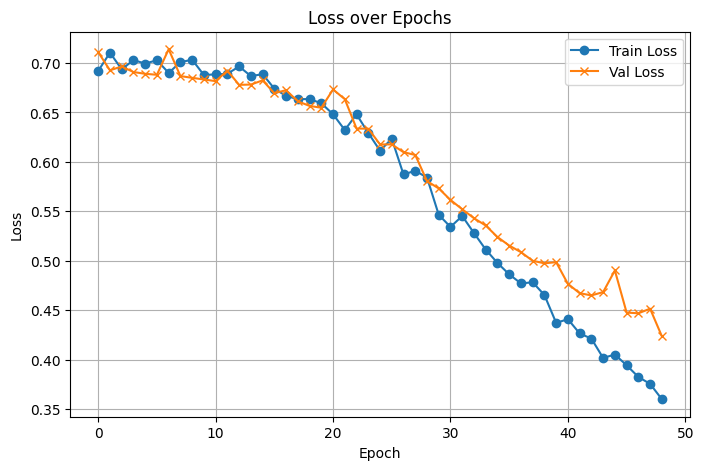

Epoch 49: train=0.3599, val=0.4236


KeyboardInterrupt: 

In [122]:
N_EPOCH = 80
train_losses, val_losses = [], []

for epoch in range(1, N_EPOCH + 1):
    perm = np.random.permutation(len(train_tokens))
    epoch_losses = []

    for i in range(0, len(perm), ft.batch_size):
        batch_idx    = perm[i : i + ft.batch_size]
        batch_toks   = [train_tokens[j] for j in batch_idx]
        batch_lbls   = train_labels[batch_idx]
        batch_df     = pd.DataFrame({"text": batch_toks, "label": batch_lbls})

        ft.backward(batch_df)
        epoch_losses.append(ft._loss_vals[-1])

    avg_train = float(np.mean(epoch_losses))
    train_losses.append(avg_train)

    val_df = pd.DataFrame({"text": val_tokens, "label": val_labels})
    vloss  = ft.eval(val_df)
    val_losses.append(vloss)

    clear_output(wait=True)
    plt.figure(figsize=(8,5))
    plt.plot(train_losses, marker='o', label='Train Loss')
    plt.plot(val_losses,   marker='x', label='Val Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss over Epochs")
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"Epoch {epoch:2d}: train={avg_train:.4f}, val={vloss:.4f}")

In [ ]:
from collections import defaultdict
import math
import pandas as pd
from tqdm import tqdm

w_diff = ft.weights[:,1] - ft.weights[:,0]
ngram_raw = defaultdict(list)
word_agg = defaultdict(lambda: [0.0, 0])

for text in tqdm(train_texts, desc="Collect diffs"):
    words       = tok._split(text)
    ngrams_lst  = [tok._ngrams(w) for w in words]
    ids_lst     = tok.encode(text)
    for w, ngrams, ids in zip(words, ngrams_lst, ids_lst):
        subsum = 0.0
        seen   = set()
        for ng, idx in zip(ngrams, ids):
            if ng in seen:
                continue
            seen.add(ng)
            diff = ft.vocab[idx].dot(w_diff)
            key  = ng if tok.subword_mask[idx] else w
            ngram_raw[key].append(diff)
            subsum += diff
        word_agg[w][0] += subsum
        word_agg[w][1] += 1

ngram_rows = []
for ng, arr in ngram_raw.items():
    mu = sum(arr) / len(arr)
    sigma = (math.sqrt(sum((x - mu)**2 for x in arr) / (len(arr)-1))
             if len(arr) > 1 else 0.0)
    ngram_rows.append((ng, mu, sigma, len(arr)))
df_ngrams = pd.DataFrame(ngram_rows, columns=['feature','mean','std','count'])
df_ngrams['abs_mean'] = df_ngrams['mean'].abs()
df_ngrams.sort_values('abs_mean', ascending=False, inplace=True)

word_rows = [(w, s/c, c) for w,(s,c) in word_agg.items() if c>0]
df_words = pd.DataFrame(word_rows, columns=['word','avg_strength','count'])
df_words['abs_strength'] = df_words['avg_strength'].abs()
df_words.sort_values('abs_strength', ascending=False, inplace=True)

print("\nTop k n-grams by |mean impact|:")
print(df_ngrams.head(50).to_string(index=False))

print("\nTop k words by |avg_strength|:")
print(df_words.head(50).to_string(index=False))

Collect diffs: 100%|██████████| 770/770 [00:14<00:00, 53.44it/s]



Top k n-grams by |mean impact|:
   feature       mean      std  count  abs_mean
      uums -40.672646 0.000000      5 40.672646
       ers -40.646748 0.890085   1225 40.646748
       ent  35.150642 1.593685   3849 35.150642
       ver  33.768570 0.000557   1970 33.768570
       bte -33.479004 0.000000      1 33.479004
       azt -33.479004 0.000000      1 33.479004
       tec -33.468811 0.215454    468 33.468811
technician -32.343513 0.000000      1 32.343513
      atec -32.343513 0.000000      1 32.343513
    techno -32.343513 0.000000      1 32.343513
 techradar -32.343513 0.000000      1 32.343513
      tech -32.161282 2.168598    383 32.161282
       ech -31.568363 0.000050    467 31.568363
       ect -28.799356 0.694009   1399 28.799356
       bsh  28.541414 0.000000      6 28.541414
       she  27.792521 4.993699    310 27.792521
 workspace -26.627930 0.000000      1 26.627930
 workhorse -26.627930 0.000000      2 26.627930
  workhomo -26.627930 0.000000      1 26.627930
workaho

: 

In [98]:
from collections import defaultdict
from tqdm import tqdm

w_diff = ft.weights[:,1] - ft.weights[:,0]

ngram_scores = defaultdict(lambda: defaultdict(float))
ngram_counts = defaultdict(lambda: defaultdict(int))

for text in tqdm(train_texts, desc="Impact"):
    words      = tok._split(text)
    ngrams_lst = [tok._ngrams(wd) for wd in words]
    ids_lst    = tok.encode(text)

    for word, ngrams, ids in zip(words, ngrams_lst, ids_lst):
        seen = set()
        for ng_str, idx in zip(ngrams, ids):
            if ng_str in seen: continue
            seen.add(ng_str)
            diff = ft.vocab[idx].dot(w_diff)
            key_ng = ng_str if tok.subword_mask[idx] else word
            ngram_scores[key_ng][word] += diff
            ngram_counts[key_ng][word] += 1

# pick the single most impactful word for each ngram
avg_impact = {}
for ng, wd_dict in ngram_scores.items():
    best_w, best_avg = max(
        ((w, s/ngram_counts[ng][w]) for w, s in wd_dict.items()),
        key=lambda x: abs(x[1])
    )
    avg_impact[f"{ng} ({best_w})"] = best_avg

# top 100 by absolute impact
top100 = sorted(avg_impact.items(), key=lambda x: -abs(x[1]))[:100]
for feat, sc in top100:
    print(f"{feat:>25s}: {sc:+.4f}")

Impact: 100%|██████████| 770/770 [00:13<00:00, 55.67it/s]


             ers (person): -23.5073
            ger (joggers): -23.5072
           uums (vacuums): -23.5072
              <te (teams): -23.0905
        tech (technology): -20.9581
            <tec (techno): -20.9581
          atec (vivatech): -20.9581
               <ma (make): -20.3869
           ers> (readers): -20.3031
           wers (skewers): -20.3031
         rder (preorders): -20.3031
            vers (movers): -20.3031
           ders (bidders): -20.3031
             iers (tiers): -20.3031
           yers (stayers): -20.3031
           lers (dealers): -20.3031
          ners (learners): -20.3031
           ters (hunters): -20.3031
          gers (changers): -20.3031
        pers (worshipers): -20.3031
         acke (gsbackers): -20.3031
        hack (biohackers): -20.3031
           kers (shakers): -20.3031
        sers (organisers): -20.3031
            hers (ushers): -20.3031
         bers (youtubers): -20.3031
         ille (oftillers): -20.3031
          mers (steamers): -